# Imports

In [2]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.utils as vision_utils
import torchvision
from matplotlib.ticker import NullFormatter
import copy
from typing import Any, Callable, List, Optional, Type, Union


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# !nvidia-smi

Tue Nov 26 08:12:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.80                 Driver Version: 546.80       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              12W /  85W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load MNIST data

In [4]:
def keep_only_lbls(dataset, lbls, device=None):
  lbls = {lbl: i for i, lbl in enumerate(lbls)}
  final_X, final_Y = [], []
  for x, y in dataset:
    if y in lbls:
      final_X.append(x)
      final_Y.append(lbls[y])
  X = torch.stack(final_X)
  Y = torch.tensor(final_Y).long()
  if device is not None:
    X = X.to(device)
    Y = Y.to(device)
  return torch.utils.data.TensorDataset(X, Y.view(-1,1).float())


data_train = MNIST('./data/mnist/', train = True, download = True, transform=transforms.ToTensor())
data_train = keep_only_lbls(data_train, lbls=[0,1], device=DEVICE)
data_train, data_valid = torch.utils.data.random_split(data_train, [10000,2665])

data_test = MNIST('./data/mnist/', train = False, download = True, transform=transforms.ToTensor())
data_test = keep_only_lbls(data_test, lbls=[0,1], device=DEVICE)

train_dl = DataLoader(data_train, batch_size=256, shuffle=True)
valid_dl = DataLoader(data_valid, batch_size=1024, shuffle=False)
test_dl = DataLoader(data_test, batch_size=1024, shuffle=False)

print(f"Train length: {len(train_dl.dataset)}")
print(f"Valid length: {len(valid_dl.dataset)}")
print(f"Test length: {len(test_dl.dataset)}")

Train length: 10000
Valid length: 2665
Test length: 2115


# Build interpolated dataset

In [5]:
def plot_samples(X, n=26):
  fig = plt.figure(figsize=(10,7), dpi=130)
  grid_img = vision_utils.make_grid(X[:n].cpu(), nrow=13, normalize=True, padding=1)
  _ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
  _ = plt.tick_params(axis=u'both', which=u'both',length=0)
  ax = plt.gca()
  _ = ax.xaxis.set_major_formatter(NullFormatter()) 
  _ = ax.yaxis.set_major_formatter(NullFormatter()) 
  plt.show()

def build_interpolated_dataset(dl, max_pairs=500, num_ts=150, device=torch.device('cpu')):
  X_test, Y_test = dl.dataset.tensors

  X_test_0 = X_test[Y_test.view(-1) == 0]
  X_test_1 = X_test[Y_test.view(-1) == 1]

  ts = torch.tensor(np.linspace(0, 1, num_ts)) * 3 - 1

  new_X_test, ts_test = [], []

  with torch.no_grad():
    for x_0, x_1 in zip(X_test_0[:max_pairs], X_test_1[:max_pairs]):
      for t in ts:
        x = t * x_1 + (1-t) * x_0
        new_X_test.append(x.cpu())
        ts_test.append(t.item())

  X_test = torch.stack(new_X_test).to(device)
  
  return X_test, ts_test

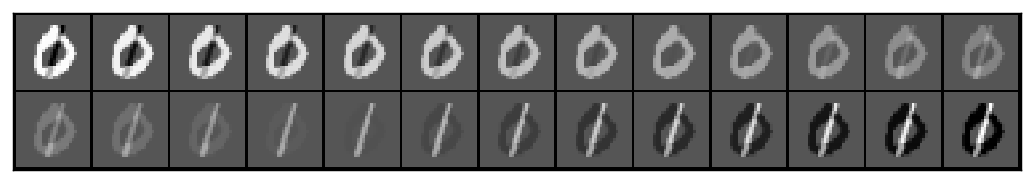

In [6]:
X_test, ts_test = build_interpolated_dataset(test_dl, max_pairs=1, num_ts=26, device=DEVICE)
plot_samples(X_test)

In [7]:
X_test, ts_test = build_interpolated_dataset(test_dl, device=DEVICE)

`X_test` consists in the interpolated $x$: $t \cdot x^{1} + (1-t) \cdot x^{0}$ for $t \in [-1,2]$ \
`ts_test` consists in the associated $t$ values

# Model

In [8]:
class LeNet(nn.Module):

  def __init__(self, num_classes=10) -> None:
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.fc1 = nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)
    self.maxPool = nn.MaxPool2d(2,2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.maxPool(F.relu(self.conv1(x)))
    x = self.maxPool(F.relu(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Training utils

In [9]:
@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    acc.append((torch.sigmoid(model(X)) > 0.5) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()


def dl_to_sampler(dl):
  dl_iter = iter(dl)
  def sample():
    nonlocal dl_iter
    try:
      return next(dl_iter)
    except StopIteration:
      dl_iter = iter(dl)
      return next(dl_iter)
  return sample


def get_probas(stats):
  with torch.no_grad():
    probas_ = []
    for m in stats['all_models']:
      probas_.append(torch.sigmoid(m(X_test)))
    probas = sum(probas_) / len(probas_)
    probas = torch.cat((probas, 1-probas), dim=1)
  return probas


def plot_entropy(entropy, ts_test):
  ts = sorted(list(set(ts_test)))

  t2idx = {t:idx for idx, t in enumerate(ts)}
  entropy_per_t = [[] for _ in range(len(t2idx))] 

  for t, p in zip(ts_test, entropy):
    idx = t2idx[t]
    entropy_per_t[idx].append(p)

  entropy_per_t = [np.mean(x) for x in entropy_per_t]

  fig, (ax) = plt.subplots(1,1,figsize=(4,3), dpi=110)
  ax.grid()
  ax.set_xlabel("$t$")
  ax.set_ylabel("uncertainty (entropy)")
  ax.plot(ts, entropy_per_t)


@torch.no_grad()
def get_ensemble_acc(models, dl):
  for model in models:
    model.eval()
  acc = []
  for X, y in dl:
    outs = [torch.sigmoid(model(X)) for model in models]
    outs = torch.stack(outs, dim=0).mean(dim=0)
    acc.append((outs > 0.5) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  return acc.item()


def sequential_train(num_models, train_dl, valid_dl, test_dl, perturb_dl, alpha=10, max_epoch=100,
                     use_diversity_reg=True, lr=0.01, weight_decay=1e-6):
  
  models = [LeNet(num_classes=1).to(DEVICE) for _ in range(num_models)]
  
  stats = {f"m{i+1}": {"acc": [], "loss": [], "adv-loss": []} for i in range(len(models))}

  for m_idx, m in enumerate(models):

    opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=weight_decay)

    perturb_sampler = dl_to_sampler(perturb_dl)

    for epoch in range(max_epoch):
      for itr, (x, y) in enumerate(train_dl):
        (x_tilde,  _) = perturb_sampler()
        erm_loss = F.binary_cross_entropy_with_logits(m(x), y)
        
        if use_diversity_reg and m_idx != 0:
          adv_loss = []
          with torch.no_grad():
            ps = [torch.sigmoid(m_(x_tilde)) for m_ in models[:m_idx]]
          psm = torch.sigmoid(m(x_tilde))
          for i in range(len(ps)):
            al = - ((1.-ps[i]) * psm + ps[i] * (1.-psm) + 1e-7).log().mean()
            adv_loss.append(al)
        else:
          adv_loss = [torch.tensor([0]).to(DEVICE)]

        adv_loss = sum(adv_loss)/len(adv_loss)
        loss = erm_loss + alpha * adv_loss

        opt.zero_grad()
        loss.backward()
        opt.step()

        if (itr + epoch * len(train_dl)) % 300 == 0:
          itr_ = itr + epoch * len(train_dl)
          print_str = f"[m{m_idx+1}] {epoch}/{itr_} [train] loss: {erm_loss.item():.2f} adv-loss: {adv_loss.item():.2f} "
          stats[f"m{m_idx+1}"]["loss"].append((itr_, erm_loss.item()))
          stats[f"m{m_idx+1}"]["adv-loss"].append((itr_, adv_loss.item()))
          acc = get_acc(m, valid_dl)
          stats[f"m{m_idx+1}"]["acc"].append((itr_, acc))
          print_str += f" acc: {acc:.2f}"
          print(print_str)
        
        itr += 1

  stats['all_models'] = models

  return stats

# Building $\mathcal{D}_\text{ood}$

Perturbations length: 47335


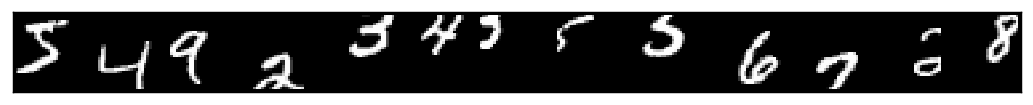

In [10]:
data_perturb = MNIST('./data/mnist/', train = True, download = True, transform=transforms.ToTensor())
data_perturb = keep_only_lbls(data_perturb, lbls=[2,3,4,5,6,7,8,9], device=DEVICE)

X, Y = data_perturb.tensors
rand_crop = torchvision.transforms.RandomCrop(28)
X = torchvision.transforms.functional.pad(X, padding=(12,12), fill=0) 
X = torch.cat([rand_crop(x.view(1,1,52,52)) for x in X])
data_perturb = TensorDataset(X, Y)

perturb_dl = DataLoader(data_perturb, batch_size=256, shuffle=True)

print(f"Perturbations length: {len(perturb_dl.dataset)}")

plot_samples(X, n=13)

# D-BAT training

[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
[m2] 0/0 [train] loss: 0.70 adv-loss: 0.69  acc: 0.47
Ensemble ACC: 0.9962
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.69  acc: 0.53
Ensemble ACC: 0.9830
[m1] 0/0 [train] loss: 0.70 adv-loss: 0.00  acc: 0.47
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.69  acc: 0.47
Ensemble ACC: 0.9650
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
[m2] 0/0 [train] loss: 0.68 adv-loss: 0.69  acc: 0.53
Ensemble ACC: 0.9939
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.47
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.69  acc: 0.53
Ensemble ACC: 0.9201
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.69  acc: 0.47
Ensemble ACC: 0.9943
[m1] 0/0 [train] loss: 0.70 adv-loss: 0.00  acc: 0.53
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.69  acc: 0.47
Ensemble ACC: 0.9953
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.47
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.69 

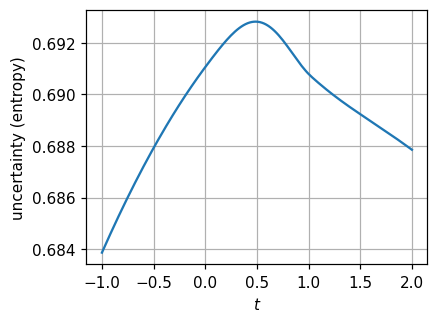

In [12]:
entropy= []
accs = []

for _ in range(10):
  stats = sequential_train(2, train_dl, valid_dl, test_dl, perturb_dl, alpha=10.0, max_epoch=1, lr=0.0001)
  accs.append(get_ensemble_acc(stats['all_models'], test_dl))
  print(f"Ensemble ACC: {accs[-1]:.4f}")
  probas = get_probas(stats)
  with torch.no_grad():
    entropy.append((-(probas * (probas+1e-8).log())).sum(dim=1).cpu())
  
with torch.no_grad():
  entropy = torch.stack(entropy, dim=0)
  entropy = entropy.mean(dim=0)
plot_entropy(entropy, ts_test)
print(f"test ensemble acc: {np.mean(accs)} +/- {np.std(accs)}")

# Deep-ensemble training

[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
[m2] 0/0 [train] loss: 0.70 adv-loss: 0.00  acc: 0.47
Ensemble ACC: 0.9206
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
Ensemble ACC: 0.9929
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
[m2] 0/0 [train] loss: 0.70 adv-loss: 0.00  acc: 0.47
Ensemble ACC: 0.9972
[m1] 0/0 [train] loss: 0.70 adv-loss: 0.00  acc: 0.47
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
Ensemble ACC: 0.9641
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.47
[m2] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.53
Ensemble ACC: 0.9948
test ensemble acc: 0.9739007234573365 +/- 0.029258543243337206


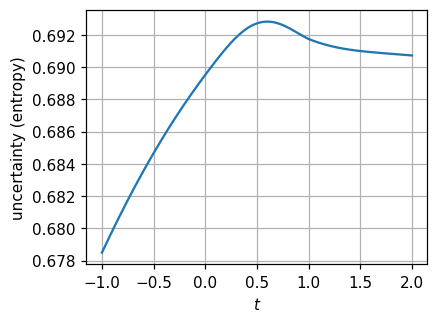

In [13]:
entropy= []
accs = []

for _ in range(5):
  stats = sequential_train(2, train_dl, valid_dl, test_dl, perturb_dl, alpha=0.0, max_epoch=1, lr=0.0001, use_diversity_reg=False)
  accs.append(get_ensemble_acc(stats['all_models'], test_dl))
  print(f"Ensemble ACC: {accs[-1]:.4f}")
  probas = get_probas(stats)
  with torch.no_grad():
    entropy.append((-(probas * (probas+1e-8).log())).sum(dim=1).cpu())
  
with torch.no_grad():
  entropy = torch.stack(entropy, dim=0)
  entropy = entropy.mean(dim=0)
plot_entropy(entropy, ts_test)
print(f"test ensemble acc: {np.mean(accs)} +/- {np.std(accs)}")